<a href="https://colab.research.google.com/github/pyreyes/solar_panel_segmentation/blob/main/Solar_Panel_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### import libraries

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')

os.chdir('gdrive/My Drive/CS7150_DeepLearning/Project/')

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from PIL import Image

#### Initial preprocessing

The dataset was obtained from the Zenodo website: https://zenodo.org/record/5171712#.YnMYQS-B2_x

The dataset images are separated into different folders, one for each resolution and one for each subcategory (rooftop, ground, crop type, etc). The labels are stored in the same folder as their corresponding image sufixed wiith '_label'.

For training with MMSegmentation all images need to be in the same folder and their labels need to be in a separate folder and have the same name.

In [ ]:
#copy all images to image folder and save labels to label folder with same name as correspoding image
import shutil

root_dir = '../PV_data'
resolution = 'PV03'
data_dir = os.path.join(root_dir)#,resolution)

image_root = 'train_data/images'
label_root = 'train_data/labels'
if not os.path.isdir(image_root):
  os.mkdir(image_root)
if not os.path.isdir(label_root):
  os.mkdir(label_root)

images = list()
labels = list()
for (dirpath, dirnames, filenames) in os.walk(data_dir):
    # img_names += [os.path.join(dirpath, file) for file in filenames]
    images += [os.path.join(dirpath, file) for file in filenames]

labels += [i for i in filter(lambda score: '_label.bmp' in score, images)]
images = [i for i in filter(lambda score: '_label.bmp' not in score, images)]

for img_path in images:
  src_path = img_path
  dst_path = os.path.join(image_root,os.path.basename(img_path))
  shutil.copy(src_path, dst_path)

for label_path in labels:
  src_path = label_path
  file_name = os.path.basename(label_path).replace('_label','')
  dst_path = os.path.join(label_root,file_name)
  shutil.copy(src_path, dst_path)

In [ ]:
#get the list of images
root_dir = 'train_data'
resolution = 'labels'
data_dir = os.path.join(root_dir,resolution)

img_names = list()
for (dirpath, dirnames, filenames) in os.walk(data_dir):
    img_names += [file[0:-4] for file in filenames]
print('Found',len(img_names),'images')


Found 3716 images


In [ ]:
#change the mask labels to 0,1 and add palette for visualizing
palette = [[0,0,0],[120,120,120]]
for img in img_names:
  org_img = np.asarray(Image.open(os.path.join('train_data/labels',img+'.bmp')))
  seg_img = np.minimum(org_img,1)
  seg_img = Image.fromarray(seg_img).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(os.path.join('train_data/labels',img+'.bmp'))

In [ ]:
# split train/val/test set randomly
import random

root_dir = 'train_data'
split_dir = 'splits'
split_path = os.path.join(root_dir,split_dir)
if not os.path.exists(split_path):
  os.makedirs(split_path)

random.shuffle(img_names)
with open(os.path.join(root_dir,split_dir,'train.txt'), 'w') as f:
  # select first 60% as train set
  train_length = int(len(img_names)*0.6)
  f.writelines(line + '\n' for line in img_names[:train_length])
with open(os.path.join(root_dir,split_dir,'val.txt'), 'w') as f:
  # select last 20% as train set
  val_length = int(len(img_names)*0.8)
  f.writelines(line + '\n' for line in img_names[train_length:val_length])

with open(os.path.join(root_dir,split_dir,'test.txt'), 'w') as f:
  # select last 20% as train set
  f.writelines(line + '\n' for line in img_names[val_length:])

In [ ]:
#create test splits for each resolution. This allows to isolate test results of each resolution
test_list = open('../train_data/splits/test.txt','r')
test_list = [t.replace('\n','') for t in test_list] 
root_dir = '../train_data'
split_dir = 'splits'
with open(os.path.join(root_dir,split_dir,'test_03.txt'), 'w') as f:
  f.writelines(line + '\n' for line in test_list if line[2:4] == '03')

with open(os.path.join(root_dir,split_dir,'test_01.txt'), 'w') as f:
f.writelines(line + '\n' for line in test_list if line[2:4] == '01')

with open(os.path.join(root_dir,split_dir,'test_08.txt'), 'w') as f:
  f.writelines(line + '\n' for line in test_list if line[2:4] == '08')

In [ ]:
#check the number of images in each split. 
splits = ['train','test','val']
for split in splits:
  f = open('train_data/splits/'+split+'.txt','r')
  t = [t.replace('\n','') for t in f]
  print(split,len(t))

train 2229
test 744
val 743


#### MMSegmentation Setup

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
# !gcc --version
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# # Install PyTorch
# !conda install pytorch=1.8.0 torchvision cudatoolkit=11.1 -c pytorch
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html


In [ ]:
# !rm -rf mmsegmentation
# !git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
# # !pip install -e .

/content/gdrive/My Drive/CS7150_DeepLearning/Project/mmsegmentation


In [ ]:
# Check MMSegmentation installation
import mmcv
import mmseg
print(mmseg.__version__)

# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

0.23.0
1.11.0+cu113 True


In [ ]:
#get the list of images
root_dir = '../train_data'
img_dir = 'images'
ann_dir = 'labels'
data_dir = os.path.join(root_dir,img_dir)

img_names = list()
for (dirpath, dirnames, filenames) in os.walk(data_dir):
    # img_names += [os.path.join(dirpath, file) for file in filenames]
    img_names += [file[0:-4] for file in filenames]

print('Found',len(img_names),'images')

Found 3716 images


In [ ]:
#splits 
splits = ['train','test','val']
for split in splits:
  f = open('../train_data/splits/'+split+'.txt','r')
  t = [t.replace('\n','') for t in f]
  print(split,len(t))

train 2229
test 744
val 743


Define the dataset

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ['no_panel','panel']
palette = [[0,0,0],[120,120,120]]

@DATASETS.register_module()
class SolarPanelDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.bmp', seg_map_suffix='.bmp', 
                     split=split, **kwargs)
#     assert os.path.exists(self.img_dir) and self.split is not None


Function to evaluate test performance

In [ ]:
from mmseg.datasets import build_dataset, build_dataloader
from mmseg.models import build_segmentor
from mmcv.parallel import MMDataParallel

def test_eval(cfg, checkpoint_file, dataset_cfg):

  dataset = build_dataset(dataset_cfg, dict(test_mode=True))
  data_loader = build_dataloader(
      dataset,
      samples_per_gpu=1,
      workers_per_gpu=cfg.data.workers_per_gpu,
      dist=False,
      shuffle=False)

  model = build_segmentor(cfg.model)

  # load model weights from checkpoint
  checkpoint = mmcv.runner.checkpoint.load_checkpoint(model,checkpoint_file)
  
  model.CLASSES = checkpoint['meta']['CLASSES']

  # put model on gpus
  model = MMDataParallel(model, device_ids=cfg.gpu_ids)
  model.eval()
  # model.eval()
  results = []
  dataset = data_loader.dataset

  prog_bar = mmcv.ProgressBar(len(dataset))
  loader_indices = data_loader.batch_sampler

  for batch_indices, data in zip(loader_indices, data_loader):
    with torch.no_grad():
      result = model(return_loss=False, **data)
      results.extend(result)

      batch_size = len(result)
      for _ in range(batch_size):
          prog_bar.update()

  eval_res = dataset.evaluate(results, metric = ['mIoU', 'mDice'])


#### Explore the dataset

In [ ]:
from torch import randint
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
class SolarPanel(Dataset):
    def __init__(self, data_dir, img_list, transform=None, target_transform=None):
        self.classes = ['no_panel','panel']
        self.palette = [0., 123./255.]
        self.img_list = img_list
        self.transform = transform
        self.target_transform = target_transform
        self.data_dir = data_dir

    def __len__(self):
        return len(self.img_list)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir,'images',self.img_list[idx]+'.bmp')
        label_path = os.path.join(self.data_dir,'labels',self.img_list[idx]+'.bmp') 
        image = Image.open(img_path)
        label = Image.open(label_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

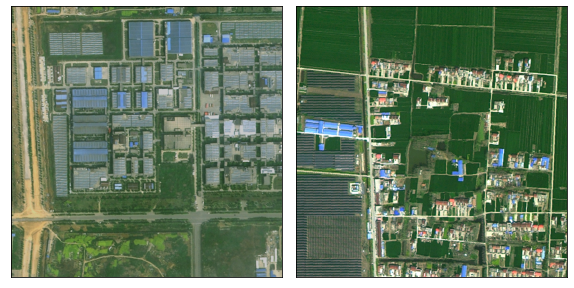

In [ ]:
train_list = open('train_data/splits/test_08.txt','r').read()
train_list = train_list.split('\n')
dataset = SolarPanel(data_dir='train_data', img_list=train_list)

figure = plt.figure(figsize=(16, 10))
rows,cols=1,2
# for i in range(1, cols*2 * rows + 1,2):
#     sample_idx = randint(len(dataset), size=(1,)).item()
#     img, mask = dataset[sample_idx]
#     figure.add_subplot(rows, cols*2, i)
#     ax = plt.gca()
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
#     plt.imshow(img)
#     figure.add_subplot(rows, cols*2, i+1)
#     plt.gca().axes.xaxis.set_visible(False)
#     ax = plt.gca()
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
#     plt.ylabel('Actual Label', fontsize = 12)
#     plt.imshow(mask)
for i in range(1, cols * rows +1,1):
    sample_idx = randint(len(dataset), size=(1,)).item()
    img, mask = dataset[sample_idx]
    figure.add_subplot(rows, cols*2, i)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(img)
    figure.tight_layout()
    # figure.add_subplot(rows, cols*2, i+1)
    # plt.gca().axes.xaxis.set_visible(False)
    # ax = plt.gca()
    # ax.axes.xaxis.set_visible(False)
    # ax.axes.yaxis.set_visible(False)
    # plt.ylabel('Actual Label', fontsize = 12)
    # plt.imshow(mask)


#### DeepLabv3+

In [ ]:
from mmseg.models import SEGMENTORS
from mmseg.apis import set_random_seed
from mmcv import Config

cfg = Config()
cfg.data_root = '../train_data'
cfg.model = dict(type = 'EncoderDecoder')
cfg.crop_size = (512, 512)
cfg.norm_cfg = dict(requires_grad=True, type='BN')
cfg.model.backbone = dict(
    type = 'ResNetV1c',
    contract_dilation= True,
    depth = 101,
    multi_grid= (1, 2, 4),
    norm_cfg = cfg.norm_cfg,
    norm_eval= False,
    num_stages = 4,
    out_indices = (0, 1, 2, 3),
    strides = (1, 2, 2, 1),
    style = 'pytorch',
)
cfg.model.decode_head = dict(
    type='DepthwiseSeparableASPPHead',
    c1_channels = 48,
    c1_in_channels = 256,
    channels = 512,
    dilations = (1, 6, 12, 18),
    dropout_ratio = 0.1,
    in_channels = 2048,
    in_index = 3,
    norm_cfg = cfg.norm_cfg,
    num_classes = 2,
    loss_decode = dict(loss_weigh=1.0, type='DiceLoss'),
)

cfg.model.test_cfg = Config(dict(mode= 'whole'))
cfg.dataset_type = 'SolarPanelDataset'
cfg.img_norm_cfg = dict(mean = [123.675, 116.28, 103.53],
                             std = [58.395, 57.12, 57.375],
                             to_rgb = True)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # Augmentation pipeline that resize the images and their annotations.
    dict(type='Resize', img_scale=cfg.crop_size, ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]
   
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024,1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
] 
cfg.data = dict(samples_per_gpu = 8, workers_per_gpu= 4)
cfg.data.train = dict(type = cfg.dataset_type,
                      data_root = cfg.data_root,
                      ann_dir = 'labels',
                      img_dir = 'images',
                      pipeline = cfg.train_pipeline,
                      split = 'splits/train.txt')

cfg.data.val = dict(type = cfg.dataset_type,
                    data_root = cfg.data_root,
                    ann_dir = 'labels',
                    img_dir = 'images',
                    pipeline = cfg.test_pipeline,
                    split = 'splits/val.txt')

cfg.data.test = Config(dict(type = cfg.dataset_type,
                    data_root = cfg.data_root,
                    ann_dir = 'labels',
                    img_dir = 'images',
                    pipeline = cfg.test_pipeline,
                    split = 'splits/test.txt'))

# Set up working dir to save files and logs.
cfg.work_dir = '../logs/deeplabv3plus/pretrain2'

#use pretrained weight initalization
# download the pretrained DeepLab v3+
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r101-d16-mg124_512x1024_40k_cityscapes/deeplabv3plus_r101-d16-mg124_512x1024_40k_cityscapes_20200908_005644-cf9ce186.pth -P checkpoints
cfg.load_from = 'checkpoints/deeplabv3plus_r101-d16-mg124_512x1024_40k_cityscapes_20200908_005644-cf9ce186.pth'
cfg.resume_from = None
cfg.workflow = [('train',1)]
cfg.cudnn_benchmark =True
cfg.optimizer = dict(
    type='AdamW',
    lr=6e-05,
    betas=(0.9, 0.999),
    weight_decay=0.01,
    paramwise_cfg=dict(
        custom_keys=dict(
            pos_block=dict(decay_mult=0.0),
            norm=dict(decay_mult=0.0),
            head=dict(lr_mult=10.0))))
cfg.lr_config = {'by_epoch': False,
 'min_lr': 1e-09,
 'warmup':'linear',
 'warmup_iters':1500,
 'warmup_ratio':1e-6,
 'policy': 'poly'}
cfg.optimizer_config = {}
cfg.runner = dict(max_iters = 2000, type = 'IterBasedRunner')
cfg.log_config = dict(hooks= [dict(by_epoch=False, type='TextLoggerHook')], interval=50)
cfg.log_level = 'INFO'
cfg.checkpoint_config = dict(by_epoch=False, interval=2000)
cfg.evaluation = dict(interval = 2000, metric = 'mIoU', pre_eval=True)
cfg.seed = 0
cfg.gpu_ids = range(1)
cfg.dist_params = dict(backend='nccl')
set_random_seed(cfg.seed, deterministic=False)
deeplab_cfg = cfg.copy()

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.apis import train_segmentor

from mmseg.models import SEGMENTORS

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the model
EncoderDecoderModel = SEGMENTORS.get('EncoderDecoder')
model_cfg = cfg.model.copy()
model_cfg.pop('type')
model_deeplab = EncoderDecoderModel(**model_cfg)

# Add an attribute for visualization convenience
model_deeplab.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_segmentor(model_deeplab, datasets, cfg, distributed=False, validate=True)

2022-05-05 15:40:40,994 - mmseg - INFO - Loaded 2229 images
2022-05-05 15:40:46,589 - mmseg - INFO - Loaded 743 images
2022-05-05 15:40:46,591 - mmseg - INFO - load checkpoint from local path: checkpoints/deeplabv3plus_r101-d16-mg124_512x1024_40k_cityscapes_20200908_005644-cf9ce186.pth
2022-05-05 15:40:48,236 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
unexpected key in source state_dict: auxiliary_head.conv_seg.weight, auxiliary_head.conv_seg.bias, auxiliary_head.convs.0.conv.weight, auxiliary_head.convs.0.bn.weight, auxiliary_head.convs.0.bn.bias, auxiliary_head.convs.0.bn.running_mean, auxiliary_head.convs.0.bn.running_var, auxil

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 743/743, 4.1 task/s, elapsed: 180s, ETA:     0s

2022-05-05 16:32:28,364 - mmseg - INFO - per class results:
2022-05-05 16:32:28,366 - mmseg - INFO - 
+----------+-------+-------+
|  Class   |  IoU  |  Acc  |
+----------+-------+-------+
| no_panel | 96.44 |  98.7 |
|  panel   | 89.06 | 92.69 |
+----------+-------+-------+
2022-05-05 16:32:28,368 - mmseg - INFO - Summary:
2022-05-05 16:32:28,371 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.24 | 92.75 | 95.69 |
+-------+-------+-------+
2022-05-05 16:32:28,375 - mmseg - INFO - Iter(val) [743]	aAcc: 0.9724, mIoU: 0.9275, mAcc: 0.9569, IoU.no_panel: 0.9644, IoU.panel: 0.8906, Acc.no_panel: 0.9870, Acc.panel: 0.9269


In [ ]:
#Get final test performance 
checkpoint_file = cfg.work_dir+'/latest.pth'
print( cfg.model.backbone,cfg.model.decode_head)
test_eval(cfg, checkpoint_file, cfg.data.test)

2022-05-05 16:32:38,942 - mmseg - INFO - Loaded 744 images


{'type': 'ResNetV1c', 'contract_dilation': True, 'depth': 101, 'multi_grid': (1, 2, 4), 'norm_cfg': {'requires_grad': True, 'type': 'BN'}, 'norm_eval': False, 'num_stages': 4, 'out_indices': (0, 1, 2, 3), 'strides': (1, 2, 2, 1), 'style': 'pytorch'} {'type': 'DepthwiseSeparableASPPHead', 'c1_channels': 48, 'c1_in_channels': 256, 'channels': 512, 'dilations': (1, 6, 12, 18), 'dropout_ratio': 0.1, 'in_channels': 2048, 'in_index': 3, 'norm_cfg': {'requires_grad': True, 'type': 'BN'}, 'num_classes': 2, 'loss_decode': {'loss_weigh': 1.0, 'type': 'DiceLoss'}}
load checkpoint from local path: ../logs/deeplabv3plus/pretrain2/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 744/744, 4.8 task/s, elapsed: 154s, ETA:     0sper class results:

+----------+-------+-------+-------+
|  Class   |  IoU  |  Acc  |  Dice |
+----------+-------+-------+-------+
| no_panel | 96.42 | 98.41 | 98.18 |
|  panel   | 88.95 | 93.45 | 94.15 |
+----------+-------+-------+-------+
Summary:

+-------+-------+-------+-------+

In [ ]:
# get test performance by resolution
from mmcv.parallel import MMDataParallel
from mmseg.datasets import build_dataset, build_dataloader

# config = Config(cfg.data.test.copy()

resolution_splits = ['splits/test_08.txt', 'splits/test_03.txt', 'splits/test_01.txt']
checkpoint_file = cfg.work_dir+'/latest.pth'

for res in resolution_splits:
  config = cfg.data.test.copy()
  config['split'] = res
  print('results for', res)
  test_eval(cfg, checkpoint_file, config)

2022-05-05 16:37:30,871 - mmseg - INFO - Loaded 153 images


results for splits/test_08.txt
load checkpoint from local path: ../logs/deeplabv3plus/pretrain2/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 153/153, 5.0 task/s, elapsed: 31s, ETA:     0sper class results:

+----------+-------+-------+-------+
|  Class   |  IoU  |  Acc  |  Dice |
+----------+-------+-------+-------+
| no_panel | 97.03 | 98.96 | 98.49 |
|  panel   | 79.78 | 85.73 | 88.75 |
+----------+-------+-------+-------+
Summary:

+-------+-------+-------+-------+
|  aAcc |  mIoU |  mAcc | mDice |
+-------+-------+-------+-------+
| 97.34 | 88.41 | 92.34 | 93.62 |
+-------+-------+-------+-------+


2022-05-05 16:38:22,055 - mmseg - INFO - Loaded 463 images


results for splits/test_03.txt
load checkpoint from local path: ../logs/deeplabv3plus/pretrain2/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 463/463, 4.9 task/s, elapsed: 94s, ETA:     0sper class results:

+----------+-------+-------+-------+
|  Class   |  IoU  |  Acc  |  Dice |
+----------+-------+-------+-------+
| no_panel |  96.2 | 98.18 | 98.06 |
|  panel   | 90.36 | 94.63 | 94.93 |
+----------+-------+-------+-------+
Summary:

+------+-------+-------+-------+
| aAcc |  mIoU |  mAcc | mDice |
+------+-------+-------+-------+
| 97.2 | 93.28 | 96.41 |  96.5 |
+------+-------+-------+-------+


2022-05-05 16:40:35,442 - mmseg - INFO - Loaded 128 images


results for splits/test_01.txt
load checkpoint from local path: ../logs/deeplabv3plus/pretrain2/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 128/128, 5.0 task/s, elapsed: 26s, ETA:     0sper class results:

+----------+-------+-------+-------+
|  Class   |  IoU  |  Acc  |  Dice |
+----------+-------+-------+-------+
| no_panel | 94.93 | 98.45 |  97.4 |
|  panel   | 86.45 | 90.05 | 92.73 |
+----------+-------+-------+-------+
Summary:

+-------+-------+-------+-------+
|  aAcc |  mIoU |  mAcc | mDice |
+-------+-------+-------+-------+
| 96.17 | 90.69 | 94.25 | 95.07 |
+-------+-------+-------+-------+


### SegFormer

In [ ]:
from mmseg.models import SEGMENTORS
from mmseg.apis import set_random_seed
from mmcv import Config

cfg = Config()
cfg.data_root = '../train_data'
cfg.model = dict(type = 'EncoderDecoder')
cfg.crop_size = (512, 512)
cfg.model.backbone = dict(
    type = 'MixVisionTransformer',
    in_channels=3,
    embed_dims = 64,
    num_stages = 4,
    # The layer number of each transformer encode layer
    num_layers = [3, 4, 18, 3],
    # num_layers = [3, 3, 3, 3],
    # the attention heads of each transformer encode layer
    num_heads = [1, 2, 5, 8],
    # the patch_size of each overlapped patch embedding
    patch_sizes = [7, 3, 3, 3],
    # the stride of each overlapped patch embedding
    strides = [4, 2, 2, 2],
    # the spatial reduction rate of each transformer encode layer
    sr_ratios = [8, 4, 2, 1],
    # Output from which stages
    out_indices = (0, 1, 2, 3),
    # ratio of mlp hidden dim to embedding dim
    mlp_ratio = 4,
    # Enable bias for qkv if True
    qkv_bias = True,
    drop_rate = 0.0,
    # The drop out rate for attention layer
    attn_drop_rate = 0.0,
    # stochastic depth rate
    drop_path_rate = 0.1,
    # Config dict for normalization layer
    norm_cfg = dict(type='LN'),
    # The activation config for FFNs
    act_cfg = dict(type='GELU'),
)
cfg.model.decode_head = dict(
    type='SegformerHead',
    in_channels = [64, 128, 320, 512],
    channels = 256,
    num_classes = 2,
    dropout_ratio = 0.1,
    # Config of norm layers
    norm_cfg = {'requires_grad': True, 'type': 'BN'},
    # Input feature index
    in_index = [0, 1, 2, 3],
    loss_decode = dict(loss_weigh=1.0, type='DiceLoss'),
)

cfg.model.test_cfg = Config(dict(crop_size= (1024,1024), 
                             mode= 'whole'))
cfg.norm_cfg = dict(requires_grad=True, type='BN')
cfg.dataset_type = 'SolarPanelDataset'
cfg.img_norm_cfg = dict(mean = [123.675, 116.28, 103.53],
                             std = [58.395, 57.12, 57.375],
                             to_rgb = True)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # Augmentation pipeline that resize the images and their annotations.
    dict(type='Resize', img_scale=cfg.crop_size, ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]
   
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024,1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
] 
cfg.data = dict(samples_per_gpu = 8, workers_per_gpu= 4)
cfg.data.train = dict(type = cfg.dataset_type,
                      data_root = cfg.data_root,
                      ann_dir = 'labels',
                      img_dir = 'images',
                      pipeline = cfg.train_pipeline,
                      split = 'splits/train.txt')

cfg.data.val = dict(type = cfg.dataset_type,
                    data_root = cfg.data_root,
                    ann_dir = 'labels',
                    img_dir = 'images',
                    pipeline = cfg.test_pipeline,
                    split = 'splits/val.txt')

cfg.data.test = dict(type = cfg.dataset_type,
                    data_root = cfg.data_root,
                    ann_dir = 'labels',
                    img_dir = 'images',
                    pipeline = cfg.test_pipeline,
                    split = 'splits/test.txt')

# Set up working dir to save files and logs.
cfg.work_dir = '../logs/segFormer/SegFormer_U'

#use pretrained weight initalization
# download the pretrained segformer-B3 weights to a checkpoint folder
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b3_8x1_1024x1024_160k_cityscapes/segformer_mit-b3_8x1_1024x1024_160k_cityscapes_20211206_224823-a8f8a177.pth -P checkpoiints
cfg.load_from = 'checkpoints/segformer_mit-b3_8x1_1024x1024_160k_cityscapes_20211206_224823-a8f8a177.pth'
cfg.resume_from = None
cfg.workflow = [('train',1)]
cfg.cudnn_benchmark =True
cfg.optimizer = dict(
    type='AdamW',
    lr=6e-05,
    betas=(0.9, 0.999),
    weight_decay=0.01,
    paramwise_cfg=dict(
        custom_keys=dict(
            pos_block=dict(decay_mult=0.0),
            norm=dict(decay_mult=0.0),
            head=dict(lr_mult=10.0))))
cfg.lr_config = {'by_epoch': False,
 'min_lr': 1e-09,
 'warmup':'linear',
 'warmup_iters':1500,
 'warmup_ratio':1e-6,
 'policy': 'poly'}
cfg.optimizer_config = {}
cfg.runner = dict(max_iters = 2000, type = 'IterBasedRunner')
cfg.log_config = dict(hooks= [dict(by_epoch=False, type='TextLoggerHook')], interval=50)
cfg.log_level = 'INFO'
cfg.checkpoint_config = dict(by_epoch=False, interval=2000)
cfg.evaluation = dict(interval = 2000, metric = 'mIoU', pre_eval=True)
cfg.seed = 0
cfg.gpu_ids = range(1)
cfg.dist_params = dict(backend='nccl')
set_random_seed(cfg.seed, deterministic=False)
segformer_cfg = cfg.copy()

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.apis import train_segmentor

from mmseg.models import SEGMENTORS

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the model
EncoderDecoderModel = SEGMENTORS.get('EncoderDecoder')
model_cfg = cfg.model.copy()
model_cfg.pop('type')
model_segformer = EncoderDecoderModel(**model_cfg)

# Add an attribute for visualization convenience
model_segformer.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_segmentor(model_segformer, datasets, cfg, distributed=False, validate=True)

2022-05-05 12:05:48,894 - mmseg - INFO - Loaded 2229 images
2022-05-05 12:05:53,329 - mmseg - INFO - Loaded 743 images
2022-05-05 12:05:53,331 - mmseg - INFO - load checkpoint from local path: checkpoints/segformer_mit-b3_8x1_1024x1024_160k_cityscapes_20211206_224823-a8f8a177.pth
2022-05-05 12:05:53,738 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
2022-05-05 12:05:53,744 - mmseg - INFO - Start running, host: root@0bd3d95b0601, work_dir: /content/gdrive/My Drive/CS7150_DeepLearning/Project/logs/segFormer/SegFormer_U
2022-05-05 12:05:53,746 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyL

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 743/743, 1.0 task/s, elapsed: 750s, ETA:     0s

2022-05-05 13:32:42,457 - mmseg - INFO - per class results:
2022-05-05 13:32:42,459 - mmseg - INFO - 
+----------+-------+-------+
|  Class   |  IoU  |  Acc  |
+----------+-------+-------+
| no_panel | 97.06 | 98.69 |
|  panel   | 91.05 | 94.79 |
+----------+-------+-------+
2022-05-05 13:32:42,460 - mmseg - INFO - Summary:
2022-05-05 13:32:42,462 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.74 | 94.06 | 96.74 |
+-------+-------+-------+
2022-05-05 13:32:42,465 - mmseg - INFO - Iter(val) [743]	aAcc: 0.9774, mIoU: 0.9406, mAcc: 0.9674, IoU.no_panel: 0.9706, IoU.panel: 0.9105, Acc.no_panel: 0.9869, Acc.panel: 0.9479


In [ ]:
#Get final test performance 
checkpoint_file = cfg.work_dir+'/latest.pth'
print( cfg.model.backbone,cfg.model.decode_head)
test_eval(cfg, checkpoint_file, cfg.data.test)

2022-05-05 14:48:31,445 - mmseg - INFO - Loaded 744 images


{'type': 'MixVisionTransformer', 'in_channels': 3, 'embed_dims': 64, 'num_stages': 4, 'num_layers': [3, 4, 18, 3], 'num_heads': [1, 2, 5, 8], 'patch_sizes': [7, 3, 3, 3], 'strides': [4, 2, 2, 2], 'sr_ratios': [8, 4, 2, 1], 'out_indices': (0, 1, 2, 3), 'mlp_ratio': 4, 'qkv_bias': True, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.1, 'norm_cfg': {'type': 'LN'}, 'act_cfg': {'type': 'GELU'}} {'type': 'SegformerHead', 'in_channels': [64, 128, 320, 512], 'channels': 256, 'num_classes': 2, 'dropout_ratio': 0.1, 'norm_cfg': {'requires_grad': True, 'type': 'BN'}, 'in_index': [0, 1, 2, 3], 'loss_decode': {'loss_weigh': 1.0, 'type': 'DiceLoss'}}
load checkpoint from local path: ../logs/segFormer/SegFormer_U/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 744/744, 3.3 task/s, elapsed: 228s, ETA:     0sper class results:

+----------+-------+-------+-------+
|  Class   |  IoU  |  Acc  |  Dice |
+----------+-------+-------+-------+
| no_panel | 97.03 | 98.43 | 98.49 |
|  panel   | 90.89 |

In [ ]:
# get test performance by resolution
from mmcv.parallel import MMDataParallel
from mmseg.datasets import build_dataset, build_dataloader


resolution_splits = ['splits/test_08.txt', 'splits/test_03.txt', 'splits/test_01.txt']
checkpoint_file = cfg.work_dir+'/latest.pth'

for res in resolution_splits:
  config = cfg.data.test.copy()
  config['split'] = res
  print('results for', res)
  test_eval(cfg, checkpoint_file, config)

results for splits/test_08.txt


2022-05-05 14:59:32,299 - mmseg - INFO - Loaded 153 images


load checkpoint from local path: ../logs/segFormer/SegFormer_U/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 153/153, 3.1 task/s, elapsed: 49s, ETA:     0sper class results:

+----------+-------+-------+-------+
|  Class   |  IoU  |  Acc  |  Dice |
+----------+-------+-------+-------+
| no_panel | 97.97 | 98.82 | 98.97 |
|  panel   | 86.41 | 93.75 | 92.71 |
+----------+-------+-------+-------+
Summary:

+------+-------+-------+-------+
| aAcc |  mIoU |  mAcc | mDice |
+------+-------+-------+-------+
| 98.2 | 92.19 | 96.28 | 95.84 |
+------+-------+-------+-------+
results for splits/test_03.txt


2022-05-05 15:00:40,787 - mmseg - INFO - Loaded 463 images


load checkpoint from local path: ../logs/segFormer/SegFormer_U/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 463/463, 3.2 task/s, elapsed: 143s, ETA:     0sper class results:

+----------+-------+-------+-------+
|  Class   |  IoU  |  Acc  |  Dice |
+----------+-------+-------+-------+
| no_panel | 96.66 | 98.27 |  98.3 |
|  panel   | 91.54 | 95.67 | 95.58 |
+----------+-------+-------+-------+
Summary:

+-------+------+-------+-------+
|  aAcc | mIoU |  mAcc | mDice |
+-------+------+-------+-------+
| 97.54 | 94.1 | 96.97 | 96.94 |
+-------+------+-------+-------+
results for splits/test_01.txt


2022-05-05 15:03:42,577 - mmseg - INFO - Loaded 128 images


load checkpoint from local path: ../logs/segFormer/SegFormer_U/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 128/128, 3.2 task/s, elapsed: 40s, ETA:     0sper class results:

+----------+-------+-------+-------+
|  Class   |  IoU  |  Acc  |  Dice |
+----------+-------+-------+-------+
| no_panel | 97.23 | 98.81 |  98.6 |
|  panel   | 92.69 | 95.64 | 96.21 |
+----------+-------+-------+-------+
Summary:

+-------+-------+-------+-------+
|  aAcc |  mIoU |  mAcc | mDice |
+-------+-------+-------+-------+
| 97.95 | 94.96 | 97.23 |  97.4 |
+-------+-------+-------+-------+


### SegForemer + Local Emphasis

#### Local Emphasis Encoder

The code below defines the local emphasis decoder.

In [ ]:
# ---------------------------------------------------------------
# Code modified from https://github.com/NVlabs/SegFormer/blob/master/mmseg/models/decode_heads/segformer_head.py
# ---------------------------------------------------------------
import numpy as np
import torch.nn as nn
import torch
from mmcv.cnn import ConvModule, DepthwiseSeparableConvModule
from collections import OrderedDict

from mmseg.ops import resize
from mmseg.models.builder import HEADS
from mmseg.models.decode_heads.decode_head import BaseDecodeHead
from mmseg.models.utils import *
import attr

from IPython import embed

class LocalEmphasis(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv1 = ConvModule(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1,
            norm_cfg=dict(type='BN', requires_grad=True)
        )
    self.conv2 = ConvModule(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=5,
            padding=2,
            norm_cfg=dict(type='BN', requires_grad=True)
        )
    
  def forward(self, x):
    _c = self.conv1(x)
    _c = self.conv2(_c)

    return _c

@HEADS.register_module()
class SegformerLEHead(BaseDecodeHead):
    """
    SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers
    """
    def __init__(self, feature_strides, **kwargs):
        super().__init__(input_transform='multiple_select', **kwargs)
        assert len(feature_strides) == len(self.in_channels)
        assert min(feature_strides) == feature_strides[0]
        self.feature_strides = feature_strides

        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = self.in_channels

        embedding_dim = 256

        self.local_emphasis_c1 = LocalEmphasis(in_channels=c1_in_channels, out_channels=embedding_dim)
        self.local_emphasis_c2 = LocalEmphasis(in_channels=c2_in_channels, out_channels=embedding_dim)
        self.local_emphasis_c3 = LocalEmphasis(in_channels=c3_in_channels, out_channels=embedding_dim)
        self.local_emphasis_c4 = LocalEmphasis(in_channels=c4_in_channels, out_channels=embedding_dim)

        self.linear_fuse = ConvModule(
            # in_channels=embedding_dim*4,
            in_channels=embedding_dim*2,
            out_channels=embedding_dim,
            kernel_size=1,
            norm_cfg=dict(type='BN', requires_grad=True)
        )

        self.linear_pred = nn.Conv2d(embedding_dim, self.num_classes, kernel_size=1)

    def forward(self, inputs):
        x = self._transform_inputs(inputs)  # len=4, 1/4,1/8,1/16,1/32
        c1, c2, c3, c4 = x

        ############## Local Emphasis decoder on C1-C4 ###########
        n, _, h, w = c4.shape

      
        _c4 = self.local_emphasis_c4(c4)
        _c4 = resize(_c4, size=c1.size()[2:],mode='bilinear',align_corners=False)

        _c3 = self.local_emphasis_c3(c3)
        _c3 = resize(_c3, size=c1.size()[2:],mode='bilinear',align_corners=False)

        _c2 = self.local_emphasis_c2(c2)
        _c2 = resize(_c2, size=c1.size()[2:],mode='bilinear',align_corners=False)

        _c1 = self.local_emphasis_c1(c1)
 
        _c = self.linear_fuse(torch.cat([_c4, _c3], dim=1))
        _c = self.linear_fuse(torch.cat([_c, _c2], dim=1))
        _c = self.linear_fuse(torch.cat([_c, _c1], dim=1))

        x = self.dropout(_c)
        x = self.linear_pred(x)

        return x

#### Run 

In [ ]:
from mmseg.models import SEGMENTORS
from mmseg.apis import set_random_seed
from mmcv import Config

cfg = Config()
cfg.data_root = '../train_data'
cfg.model = dict(type = 'EncoderDecoder')
cfg.crop_size = (512, 512)
cfg.model.backbone = dict(
    type = 'MixVisionTransformer',
    in_channels=3,
    embed_dims = 64,
    num_stages = 4,
    # The layer number of each transformer encode layer
    num_layers = [3, 4, 18, 3],
    # num_layers = [3, 3, 3, 3],
    # the attention heads of each transformer encode layer
    num_heads = [1, 2, 5, 8],
    # the patch_size of each overlapped patch embedding
    patch_sizes = [7, 3, 3, 3],
    # the stride of each overlapped patch embedding
    strides = [4, 2, 2, 2],
    # the spatial reduction rate of each transformer encode layer
    sr_ratios = [8, 4, 2, 1],
    # Output from which stages
    out_indices = (0, 1, 2, 3),
    # ratio of mlp hidden dim to embedding dim
    mlp_ratio = 4,
    # Enable bias for qkv if True
    qkv_bias = True,
    drop_rate = 0.0,
    # The drop out rate for attention layer
    attn_drop_rate = 0.0,
    # stochastic depth rate
    drop_path_rate = 0.1,
    # Config dict for normalization layer
    norm_cfg = dict(type='LN'),
    # The activation config for FFNs
    act_cfg = dict(type='GELU'),
)

# cfg.model.decode_head.align_corners = False
cfg.model.decode_head = dict(type='SegformerLEHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels= 256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg={'requires_grad': True, 'type': 'BN'},
        align_corners=False,
        loss_decode=dict(type='DiceLoss', loss_weight=1.0),
        )

cfg.model.test_cfg = Config(dict(mode= 'whole'))
cfg.norm_cfg = dict(requires_grad=True, type='BN')
cfg.dataset_type = 'SolarPanelDataset'
cfg.img_norm_cfg = dict(mean = [123.675, 116.28, 103.53],
                             std = [58.395, 57.12, 57.375],
                             to_rgb = True)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # Augmentation pipeline that resize the images and their annotations.
    dict(type='Resize', img_scale=cfg.crop_size, ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]
   
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024,1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
] 
cfg.data = dict(samples_per_gpu = 8, workers_per_gpu= 4)
cfg.data.train = dict(type = cfg.dataset_type,
                      data_root = cfg.data_root,
                      ann_dir = 'labels',
                      img_dir = 'images',
                      pipeline = cfg.train_pipeline,
                      split = 'splits/train.txt')

cfg.data.val = dict(type = cfg.dataset_type,
                    data_root = cfg.data_root,
                    ann_dir = 'labels',
                    img_dir = 'images',
                    pipeline = cfg.test_pipeline,
                    split = 'splits/val.txt')

cfg.data.test = dict(type = cfg.dataset_type,
                    data_root = cfg.data_root,
                    ann_dir = 'labels',
                    img_dir = 'images',
                    pipeline = cfg.test_pipeline,
                    split = 'splits/test.txt')

# Set up working dir to save files and logs.
cfg.work_dir = '../logs/segFormer/SegFormer+LE'

#use pretrained weight initalization
cfg.load_from = 'checkpoints/segformer_mit-b3_8x1_1024x1024_160k_cityscapes_20211206_224823-a8f8a177.pth'
cfg.resume_from = None
cfg.workflow = [('train',1)]
cfg.cudnn_benchmark =True
cfg.optimizer = dict(
    type='AdamW',
    lr=6e-05,
    betas=(0.9, 0.999),
    weight_decay=0.01,
    paramwise_cfg=dict(
        custom_keys=dict(
            pos_block=dict(decay_mult=0.0),
            norm=dict(decay_mult=0.0),
            head=dict(lr_mult=10.0))))
cfg.lr_config = {'by_epoch': False,
 'min_lr': 1e-09,
 'warmup':'linear',
 'warmup_iters':1500,
 'warmup_ratio':1e-6,
 'policy': 'poly'}
cfg.optimizer_config = {}
cfg.runner = dict(max_iters = 2000, type = 'IterBasedRunner')
cfg.log_config = dict(hooks= [dict(by_epoch=False, type='TextLoggerHook')], interval=50)
cfg.log_level = 'INFO'
cfg.checkpoint_config = dict(by_epoch=False, interval=2000)
cfg.evaluation = dict(interval = 2000, metric = 'mIoU', pre_eval=True)
cfg.seed = 0
cfg.gpu_ids = range(1)
cfg.dist_params = dict(backend='nccl')
set_random_seed(cfg.seed, deterministic=False)

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.apis import train_segmentor

from mmseg.models import SEGMENTORS


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the model
EncoderDecoderModel = SEGMENTORS.get('EncoderDecoder')
model_cfg = cfg.model.copy()
model_cfg.pop('type')
model_segformer = EncoderDecoderModel(**model_cfg)

# Add an attribute for visualization convenience
model_segformer.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_segmentor(model_segformer, datasets, cfg, distributed=False, validate=True)

2022-05-05 17:34:43,769 - mmseg - INFO - Loaded 2229 images
2022-05-05 17:34:44,381 - mmseg - INFO - Loaded 743 images
2022-05-05 17:34:44,383 - mmseg - INFO - load checkpoint from local path: checkpoints/segformer_mit-b3_8x1_1024x1024_160k_cityscapes_20211206_224823-a8f8a177.pth
2022-05-05 17:34:45,211 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
unexpected key in source state_dict: decode_head.convs.0.conv.weight, decode_head.convs.0.bn.weight, decode_head.convs.0.bn.bias, decode_head.convs.0.bn.running_mean, decode_head.convs.0.bn.running_var, decode_head.convs.0.bn.num_batches_tracked, decode_head.convs.1.conv.weight, decode_head

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 743/743, 2.4 task/s, elapsed: 311s, ETA:     0s

2022-05-05 19:14:01,297 - mmseg - INFO - per class results:
2022-05-05 19:14:01,299 - mmseg - INFO - 
+----------+-------+-------+
|  Class   |  IoU  |  Acc  |
+----------+-------+-------+
| no_panel | 96.61 | 98.33 |
|  panel   | 89.77 | 94.46 |
+----------+-------+-------+
2022-05-05 19:14:01,300 - mmseg - INFO - Summary:
2022-05-05 19:14:01,302 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.39 | 93.19 | 96.39 |
+-------+-------+-------+
2022-05-05 19:14:01,305 - mmseg - INFO - Iter(val) [743]	aAcc: 0.9739, mIoU: 0.9319, mAcc: 0.9639, IoU.no_panel: 0.9661, IoU.panel: 0.8977, Acc.no_panel: 0.9833, Acc.panel: 0.9446


In [ ]:
#Get final test performance 
checkpoint_file = cfg.work_dir+'/latest.pth'
print( cfg.model.backbone,cfg.model.decode_head)
test_eval(cfg, checkpoint_file, cfg.data.test)

2022-05-05 19:18:53,226 - mmseg - INFO - Loaded 744 images


{'type': 'MixVisionTransformer', 'in_channels': 3, 'embed_dims': 64, 'num_stages': 4, 'num_layers': [3, 4, 18, 3], 'num_heads': [1, 2, 5, 8], 'patch_sizes': [7, 3, 3, 3], 'strides': [4, 2, 2, 2], 'sr_ratios': [8, 4, 2, 1], 'out_indices': (0, 1, 2, 3), 'mlp_ratio': 4, 'qkv_bias': True, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.1, 'norm_cfg': {'type': 'LN'}, 'act_cfg': {'type': 'GELU'}} {'type': 'SegformerLEHead', 'in_channels': [64, 128, 320, 512], 'in_index': [0, 1, 2, 3], 'feature_strides': [4, 8, 16, 32], 'channels': 256, 'dropout_ratio': 0.1, 'num_classes': 2, 'norm_cfg': {'requires_grad': True, 'type': 'BN'}, 'align_corners': False, 'loss_decode': {'type': 'DiceLoss', 'loss_weight': 1.0}}
load checkpoint from local path: ../logs/segFormer/SegFormer+LE/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 744/744, 2.7 task/s, elapsed: 278s, ETA:     0sper class results:

+----------+-------+-------+------+
|  Class   |  IoU  |  Acc  | Dice |
+----------+-------+-------+-----

In [ ]:
# get test performance by resolution
from mmcv.parallel import MMDataParallel
from mmseg.datasets import build_dataset, build_dataloader


resolution_splits = ['splits/test_08.txt', 'splits/test_03.txt', 'splits/test_01.txt']
checkpoint_file = cfg.work_dir+'/latest.pth'

for res in resolution_splits:
  config = cfg.data.test.copy()
  config['split'] = res
  print('results for', res)
  test_eval(cfg, checkpoint_file, config)

2022-05-05 19:24:49,464 - mmseg - INFO - Loaded 153 images


results for splits/test_08.txt
load checkpoint from local path: ../logs/segFormer/SegFormer+LE/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 153/153, 2.7 task/s, elapsed: 57s, ETA:     0sper class results:

+----------+-------+-------+-------+
|  Class   |  IoU  |  Acc  |  Dice |
+----------+-------+-------+-------+
| no_panel | 97.55 | 98.51 | 98.76 |
|  panel   | 83.91 |  92.9 | 91.25 |
+----------+-------+-------+-------+
Summary:

+-------+-------+-------+-------+
|  aAcc |  mIoU |  mAcc | mDice |
+-------+-------+-------+-------+
| 97.82 | 90.73 | 95.71 | 95.01 |
+-------+-------+-------+-------+


2022-05-05 19:26:07,799 - mmseg - INFO - Loaded 463 images


results for splits/test_03.txt
load checkpoint from local path: ../logs/segFormer/SegFormer+LE/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 463/463, 2.6 task/s, elapsed: 177s, ETA:     0sper class results:

+----------+-------+-------+-------+
|  Class   |  IoU  |  Acc  |  Dice |
+----------+-------+-------+-------+
| no_panel | 96.58 | 97.89 | 98.26 |
|  panel   | 91.44 | 96.45 | 95.53 |
+----------+-------+-------+-------+
Summary:

+-------+-------+-------+-------+
|  aAcc |  mIoU |  mAcc | mDice |
+-------+-------+-------+-------+
| 97.49 | 94.01 | 97.17 | 96.89 |
+-------+-------+-------+-------+


2022-05-05 19:29:44,461 - mmseg - INFO - Loaded 128 images


results for splits/test_01.txt
load checkpoint from local path: ../logs/segFormer/SegFormer+LE/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 128/128, 2.5 task/s, elapsed: 51s, ETA:     0sper class results:

+----------+-------+-------+-------+
|  Class   |  IoU  |  Acc  |  Dice |
+----------+-------+-------+-------+
| no_panel | 97.09 | 98.33 | 98.52 |
|  panel   | 92.42 | 96.57 | 96.06 |
+----------+-------+-------+-------+
Summary:

+-------+-------+-------+-------+
|  aAcc |  mIoU |  mAcc | mDice |
+-------+-------+-------+-------+
| 97.85 | 94.76 | 97.45 | 97.29 |
+-------+-------+-------+-------+


####Evaluation

In [ ]:
if 'log_vars' in outputs:
            runner.log_buffer.update(outputs['log_vars'], outputs['num_samples'])
runner.outputs = outputs

In [ ]:
runner.outputs = outputs
runner.call_hook('after_train_iter')
runner._inner_iter += 1
runner._iter += 1

2022-04-16 21:03:36,696 - mmseg - INFO - Saving checkpoint at 2 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 743/743, 7.8 task/s, elapsed: 95s, ETA:     0s

2022-04-16 21:05:12,980 - mmseg - INFO - per class results:
2022-04-16 21:05:12,983 - mmseg - INFO - 
+----------+-------+-------+
|  Class   |  IoU  |  Acc  |
+----------+-------+-------+
| no_panel | 95.42 | 98.35 |
|  panel   |  86.0 | 90.43 |
+----------+-------+-------+
2022-04-16 21:05:12,984 - mmseg - INFO - Summary:
2022-04-16 21:05:12,986 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.43 | 90.71 | 94.39 |
+-------+-------+-------+
2022-04-16 21:05:12,989 - mmseg - INFO - Iter(val) [743]	aAcc: 0.9643, mIoU: 0.9071, mAcc: 0.9439, IoU.no_panel: 0.9542, IoU.panel: 0.8600, Acc.no_panel: 0.9835, Acc.panel: 0.9043


In [ ]:
for hook in runner._hooks:
   getattr(hook,'after_train_iter')

<bound method Hook.after_train_iter of <mmcv.runner.hooks.lr_updater.PolyLrUpdaterHook object at 0x7fbd5feefad0>>
<bound method OptimizerHook.after_train_iter of <mmcv.runner.hooks.optimizer.OptimizerHook object at 0x7fbd5feefb50>>
<bound method CheckpointHook.after_train_iter of <mmcv.runner.hooks.checkpoint.CheckpointHook object at 0x7fbd5feefc10>>
<bound method Hook.after_train_iter of <mmcv.runner.hooks.iter_timer.IterTimerHook object at 0x7fbd5feefb90>>
<bound method EvalHook.after_train_iter of <mmseg.core.evaluation.eval_hooks.EvalHook object at 0x7fbd5feeff10>>
<bound method LoggerHook.after_train_iter of <mmcv.runner.hooks.logger.text.TextLoggerHook object at 0x7fbd5feefc50>>


In [ ]:
getattr(runner._hooks[4],'after_train_iter')(runner)

In [ ]:
evalhook = runner._hooks[4]
evalhook._do_evaluate(runner)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 743/743, 1.5 task/s, elapsed: 508s, ETA:     0s

2022-04-17 13:43:52,196 - mmseg - INFO - per class results:
2022-04-17 13:43:52,198 - mmseg - INFO - 
+----------+-------+-------+
|  Class   |  IoU  |  Acc  |
+----------+-------+-------+
| no_panel | 95.18 | 98.21 |
|  panel   | 85.31 | 90.08 |
+----------+-------+-------+
2022-04-17 13:43:52,199 - mmseg - INFO - Summary:
2022-04-17 13:43:52,201 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.24 | 90.25 | 94.14 |
+-------+-------+-------+


In [ ]:
#_do_evaluate
evalhook = runner._hooks[4]
results = evalhook.test_fn(runner.model, evalhook.dataloader)
runner.log_buffer.output['eval_iter_num'] = len(evalhook.dataloader)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 743/743, 10.1 task/s, elapsed: 73s, ETA:     0s

### Inference

In [ ]:
from mmseg.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter
from mmseg.models import build_segmentor
def inference(cfg, checkpoint_file, filename, labelname=None):
  model = build_segmentor(cfg.model)
  # load model weights from checkpoint
  checkpoint = mmcv.runner.checkpoint.load_checkpoint(model,checkpoint_file)
  model.CLASSES = checkpoint['meta']['CLASSES']
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  img = mmcv.imread(filename)
  # ann = mmcv.imread(labelname)
  results = dict(img=img, img_info=dict(filename=filename))

  test_pipeline = cfg.data.test.pipeline
  test_pipeline = Compose(test_pipeline)
  data = test_pipeline(results)
  data = collate([data], samples_per_gpu=1)
  data = scatter(data, [device])[0]
  with torch.no_grad():
      result = model(return_loss=False, rescale=True, **data)
  seg = result[0]
  import matplotlib.pyplot as plt
  palette = [[0,0,0],[220,0,220]]
  predicted_mask = model.show_result(img,result,palette=palette,show=False,opacity=0.4)
  palette = np.array(palette)
  # color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
  # for label, color in enumerate(palette):
  #     color_seg[seg == label, :] = color
  # # convert to BGR
  # color_seg = color_seg[..., ::-1]

  plt.figure(figsize=(15, 10))
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  
  plt.imshow(mmcv.bgr2rgb(predicted_mask))

load checkpoint from local path: ../logs/deeplabv3plus/pretrain2/latest.pth


/content/gdrive/My Drive/CS7150_DeepLearning/Project/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


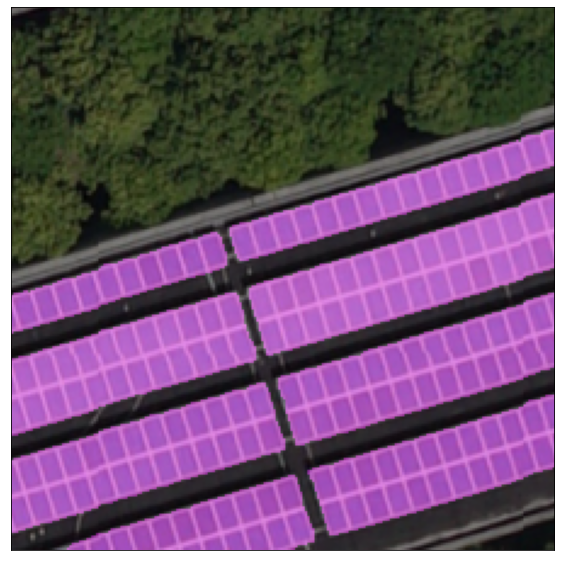

In [ ]:
root_dir = '../inference_images'
img_dir = ''

img_dir = os.path.join(root_dir,img_dir)
name = '30'
filename = img_dir+name+'.bmp'

inference(deeplab_cfg, '../logs/deeplabv3plus/pretrain2/latest.pth', filename)